# 【全人類がわかるE資格コース】コーディング演習Day4

## 概要

本演習では深層学習の基礎である多層パーセプトロンによる学習を穴埋め形式で実装します。なお、予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
演習問題文は<font color="Red">赤字</font>です。このファイルは必ず最後までコードをすべて実行し、「最後までコードが実行可能」・「学習結果の出力がある」・「学習が成功している」の３つを満たした状態で提出してください。

また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：2~4時間

## ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [32]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
from pdb import set_trace
# 乱数シードを指定
np.random.seed(seed=0)

In [33]:
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784')
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)
x_train = x_train.reshape(-1,1,28,28)
x_test = x_test.reshape(-1,1,28,28)
# ラベルデータをint型にし、one-hot-vectorに変換します
t_train = np.eye(10)[t_train.astype("int")]
t_test = np.eye(10)[t_test.astype("int")]

## データの説明

mnist と呼ばれる手書き数字の認識問題です。

データは 1チャンネル 28×28 の配列となっています。

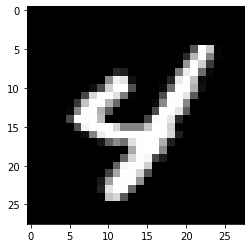

label:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


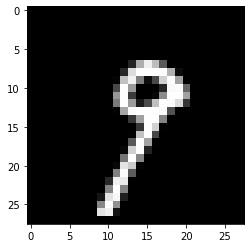

label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


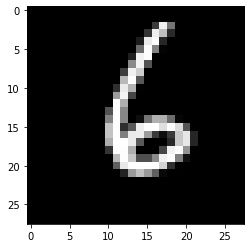

label:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


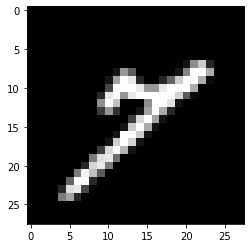

label:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


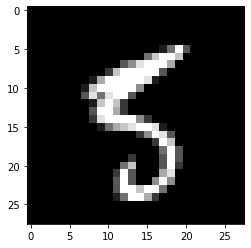

label:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [34]:
# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(x_train[i][0])
    plt.show()
    print("label: ", t_train[i])

### Affine 変換層とコスト関数
Affine 変換層とコスト関数の実装になります。問題にはなっていませんが、復習も兼ねて読み返してください。

In [35]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [36]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

class Affine:
    def __init__(self, input_size, output_size):
        self.W = 0.01 * np.random.randn(input_size, output_size)
        self.b = np.zeros(output_size)
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## im2col, col2im
画像データに対する畳み込みなどの演算を行列積として実装するため、四次元配列である画像を二次元配列へと変換する関数`im2col`、逆伝播用の逆変換`col2im`を実装します。

1. <font color="Red">画像データを二次元配列へと変換する関数`im2col`を完成させてください。</font>

画像データにフィルタをそのまま適用してしまうと計算に時間がかかることが知られています。(numpyは行列計算が高速にできるようになっており、逆にfor文には時間がかかるため。)そこで、今回はこの処理を行列演算で行っていきます。<br>
im2colの手順としては<br>
　- 高次元配列を二次元配列に変換する。(①フィルタの行列変換、②画像データの行列変換)<br>
　- 行列積を求める。<br>
　- 行列を高次元配列に変換する。<br>
となります。
<img src="img/im2col_outline.png">

### ①フィルタの行列変換
画像データだけではなく、フィルタのデータも多次元です。im2colを考える前に、このフィルタをどのように行列化するかを考えていきます。

まずは配列の表記にして考えてみましょう。ここでは元々のフィルタをfilter_org(FN, C, FH, FW)と記載することとします。
フィルタの数がFN個あり、これらを画像データ群に適用させる必要があります。
画像データの配列と行列積を行うためには、縦方向に「一つのフィルタの情報」を格納し、そのフィルタ情報を横に並べる形をとります。
行列の縦方向は「フィルタのデータ（C×FH×FW）」が入ります。フィルタの行列としてはfilter_col(C×FH×FW, FN)となります。<br>
また、よくある間違い例として<font color="Red">filter_org(FN, C, FH, FW)から変換せずに、いきなりreshapeを行ってしまう</font>という例があります。<br>
numpy.reshapeは先頭からデータを取ってくるので、filter_org(FN, C, FH, FW)はFN→C→FH→FWの順番でデータを取ってきます。しかし、filter_col(C×FH×FW, FN)の順番はC→FH→FW→FNとなっているため、これでは上手くいきません。あらかじめfilter_org(FN, C, FH, FW)をfilter_org(C, FH, FW, FN)に変換する必要があります。
<img src="img/im2col_filter.png">

### ②画像データの行列変換
続いてどのようなサイズの行列にすべきかを考えます。
フィルタのサイズはfilter_col(C×FH×FW, FN)です。行列変換後の画像ファイルをim_colとすると、im_colとfilter_colとの行列積を求めるためには、im_colの列のサイズはfilter_colの行のサイズと同じにする必要があります。つまり、C×FH×FWです。
<img src="img/im2col_image.png">

次に、im_colの縦方向にはどのような値を入れるのかを考えます。<br>
filter_colの行列積を取ることを考えると、1列目にはフィルタ"0"が掛け合わされます。2列目にはフィルタ"1”、3列目は、・・・・というふうにつながります。
<img src="img/im2col_stride.png">

ここでOHは出力データの高さ、OWは出力データの幅だったので、値の個数は（N×OH×OW）となります。<br>
Nは画像データの数です。OH,OWですが、これは畳み込み後のデータサイズを表します。<br>
結論として、画像データの変換後サイズは　im_col(N×OH×W, C×FH×FW) となります。<br>
im2colの説明は以上です。それでは実際にim2colを実装していきましょう。<br>
<img src="img/im2col.png">

In [37]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape

    # カーネルを適用した際、出力の画像サイズがどうなるかを計算
    out_h = int((H - filter_h + 2*pad)/stride) + 1 #### 問1-1 ####
    out_w = int((W - filter_w + 2*pad)/stride) + 1 #### 問1-2 ####

#   img = np.pad(input_data, #### 問1-3 #### , 'constant') 
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
#   img : N, C, H+2pad, W+2pad
#   col : N, C, FH    , FW    , OH, OW
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
#           col[:, :, y, x, :, :] = img[#### 問1-4 #### ]
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride ]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

### 確認用セル
以下のセルを実行して`im2col`の実装が正しいか確認してください。

In [38]:
dummy_imgs = np.arange(135).reshape(5,3,3,3)
dummy_kernels = np.arange(48).reshape(4,3,2,2)
dummy_conv = np.dot(im2col(dummy_imgs, 2,2, pad=1), dummy_kernels.reshape(4,12).T)

In [39]:
ans = np.array([[  261.,   585.,   909.,  1233.],
       [  516.,  1200.,  1884.,  2568.],
       [  555.,  1311.,  2067.,  2823.],
       [  270.,   666.,  1062.,  1458.],
       [  531.,  1287.,  2043.,  2799.],
       [ 1035.,  2619.,  4203.,  5787.],
       [ 1101.,  2829.,  4557.,  6285.],
       [  528.,  1428.,  2328.,  3228.],
       [  639.,  1611.,  2583.,  3555.],
       [ 1233.,  3249.,  5265.,  7281.],
       [ 1299.,  3459.,  5619.,  7779.],
       [  618.,  1734.,  2850.,  3966.],
       [  297.,   837.,  1377.,  1917.],
       [  564.,  1680.,  2796.,  3912.],
       [  591.,  1779.,  2967.,  4155.],
       [  276.,   888.,  1500.,  2112.],
       [  828.,  2124.,  3420.,  4716.],
       [ 1569.,  4197.,  6825.,  9453.],
       [ 1608.,  4308.,  7008.,  9708.],
       [  756.,  2124.,  3492.,  4860.],
       [ 1503.,  4203.,  6903.,  9603.],
       [ 2817.,  8289., 13761., 19233.],
       [ 2883.,  8499., 14115., 19731.],
       [ 1338.,  4182.,  7026.,  9870.],
       [ 1611.,  4527.,  7443., 10359.],
       [ 3015.,  8919., 14823., 20727.],
       [ 3081.,  9129., 15177., 21225.],
       [ 1428.,  4488.,  7548., 10608.],
       [  702.,  2214.,  3726.,  5238.],
       [ 1293.,  4353.,  7413., 10473.],
       [ 1320.,  4452.,  7584., 10716.],
       [  600.,  2184.,  3768.,  5352.],
       [ 1395.,  3663.,  5931.,  8199.],
       [ 2622.,  7194., 11766., 16338.],
       [ 2661.,  7305., 11949., 16593.],
       [ 1242.,  3582.,  5922.,  8262.],
       [ 2475.,  7119., 11763., 16407.],
       [ 4599., 13959., 23319., 32679.],
       [ 4665., 14169., 23673., 33177.],
       [ 2148.,  6936., 11724., 16512.],
       [ 2583.,  7443., 12303., 17163.],
       [ 4797., 14589., 24381., 34173.],
       [ 4863., 14799., 24735., 34671.],
       [ 2238.,  7242., 12246., 17250.],
       [ 1107.,  3591.,  6075.,  8559.],
       [ 2022.,  7026., 12030., 17034.],
       [ 2049.,  7125., 12201., 17277.],
       [  924.,  3480.,  6036.,  8592.],
       [ 1962.,  5202.,  8442., 11682.],
       [ 3675., 10191., 16707., 23223.],
       [ 3714., 10302., 16890., 23478.],
       [ 1728.,  5040.,  8352., 11664.],
       [ 3447., 10035., 16623., 23211.],
       [ 6381., 19629., 32877., 46125.],
       [ 6447., 19839., 33231., 46623.],
       [ 2958.,  9690., 16422., 23154.],
       [ 3555., 10359., 17163., 23967.],
       [ 6579., 20259., 33939., 47619.],
       [ 6645., 20469., 34293., 48117.],
       [ 3048.,  9996., 16944., 23892.],
       [ 1512.,  4968.,  8424., 11880.],
       [ 2751.,  9699., 16647., 23595.],
       [ 2778.,  9798., 16818., 23838.],
       [ 1248.,  4776.,  8304., 11832.],
       [ 2529.,  6741., 10953., 15165.],
       [ 4728., 13188., 21648., 30108.],
       [ 4767., 13299., 21831., 30363.],
       [ 2214.,  6498., 10782., 15066.],
       [ 4419., 12951., 21483., 30015.],
       [ 8163., 25299., 42435., 59571.],
       [ 8229., 25509., 42789., 60069.],
       [ 3768., 12444., 21120., 29796.],
       [ 4527., 13275., 22023., 30771.],
       [ 8361., 25929., 43497., 61065.],
       [ 8427., 26139., 43851., 61563.],
       [ 3858., 12750., 21642., 30534.],
       [ 1917.,  6345., 10773., 15201.],
       [ 3480., 12372., 21264., 30156.],
       [ 3507., 12471., 21435., 30399.],
       [ 1572.,  6072., 10572., 15072.]])

if (dummy_conv == ans).all():
    print("im2col の実装に問題はありません。先に進んでください。")
else:
    print("im2col の実装に問題があります。解き直してください。")

im2col の実装に問題はありません。先に進んでください。


2. <font color="Red">二次元配列での勾配を四次元配列の画像データでの勾配へと変換する関数`col2im`を完成させてください。</font>

 - `col2im` の実装問題は、問1の解答と同じコードで問題ありません。 

In [48]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = input_shape
    out_h = int((H - filter_h + 2*pad)/stride ) + 1 #### 問2-1 (問1-1 と同じ) ####
    out_w = int((W - filter_w + 2*pad)/stride ) + 1 #### 問2-2 (問1-2 と同じ) ####
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
#           img[#### 問2-3 (問1-4 と同じ) ####] += col[:, :, y, x, :, :]
            img[ :, :, y:y_max:stride, x:x_max:stride ] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## Convolution
3. <font color="Red">作成した`im2col`, `col2im`を使用し、畳み込み層 `convolution` を完成させてください。</font>

In [56]:
class Convolution:
    def __init__(self, input_channel, output_channel, kernel_h=5, kernel_w=5, stride=1, pad=0):
        self.W = 0.01 * np.random.randn(output_channel, input_channel, kernel_h, kernel_w)
        self.b = np.zeros(output_channel)
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int( ( H - FH + 2*self.pad )/self.stride ) + 1 #### 問3-1 ####
        out_w = int( ( W - FW + 2*self.pad )/self.stride ) + 1 #### 問3-2 ####

        col = im2col(x, FH, FW, self.stride, self.pad)
 #       col_W = self.W.reshape(FN,-1).T #### 問3-3 ####
        col_W = self.W.transpose(1,2,3,0).reshape(-1,FN) #### 問3-3 ####

        #try:
        out = np.dot(col,col_W) + self.b #### 問3-4 ####
        #except:
        #    set_trace()
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
#        set_trace()
#        assert dout.shape == self.x.shape,f'{dout.shape} {self.col_W.shape}'
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

## Pooling の実装
4. <font color="Red">作成した`im2col`, `col2im`を使用し、畳み込み層 `pooling` を完成させてください。</font>

In [57]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(( H - self.pool_h + 2*self.pad )/self.stride ) + 1 #### 問4-1 ####
        out_w = int(( W - self.pool_w + 2*self.pad )/self.stride ) + 1 #### 問4-2 ####

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
#        out = #### 問4-3 ####
#        out = col[range(arg_max.size), arg_max] #### 問4-3 ####
#        out = np.max(col, axis=1).reshape(N,out_h, out_w, C).transpose(0,3,1,2) #### 問4-3 ####
        out = np.max(col, axis=1) #### 問4-3 ####

        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## ネットワーク定義

In [58]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), output_size=10, weight_init_std=0.01):
 
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(1,10,5,5)
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] =Convolution(10,10,5,5)
        self.layers['Relu2'] = Relu()
        self.layers['Affine'] = Affine(640, 10)

        self.last_layer = SoftmaxWithLoss()
        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = self.layers['Conv1'].W
        self.params['b1'] = self.layers['Conv1'].b
        self.params['W2'] = self.layers['Conv2'].W
        self.params['b2'] = self.layers['Conv2'].b
        self.params['W3'] = self.layers['Affine'].W
        self.params['b3'] = self.layers['Affine'].b


    def forward(self, x):
        idx=0
        for layer in self.layers.values():
            x = layer.forward(x)
            idx+=1

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.forward(x)
        return self.last_layer.forward(y, t)

    def backward(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Affine'].dW, self.layers['Affine'].db

        return grads

## 学習
5エポックで精度が95%以上になっていれば学習成功です。

convolution や pooling はGPUでは高速ですが、CPUで実行した場合は非常に実行時間がかかるため、学習セルの実行には時間を要します。10~15分ほど要しますので、ご注意ください。

In [59]:
network = SimpleConvNet(input_dim=(1,28,28),  output_size=10, weight_init_std=0.01)

In [60]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

In [61]:
acc_list = []
sgd = SGD(lr = 0.01)
batch_size = 256

In [ ]:
for epoch in range(5):
    perm = np.random.permutation(len(x_train))
    for idx in np.arange(0, len(perm), batch_size):
        x = x_train[perm[idx:idx+batch_size]]
        t =  t_train[perm[idx:idx+batch_size]]

        grads = network.backward(x, t)
        sgd.update(network.params,grads)
    y_test = network.forward(x_test)
    acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())

    print(f'EPOCH {epoch + 1} | ACCURACY {acc_list[-1]:.2%}')

EPOCH 1 | ACCURACY 95.23%
EPOCH 2 | ACCURACY 96.77%
